# Mount Google drive

**Note**: before proceeing, open [this Google Drive folder](https://drive.google.com/drive/folders/11VDHTT7Era4TV0gqjL-FtdnPUqovpZPe) and then click "Add shortcut to Drive" in the context menu for that folder and then choose MyDrive.

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(os.listdir('/content/drive/MyDrive/Hinton_Project'))

['hinton', 'hinton.zip', 'small', 'data', '.ipynb_checkpoints', 'data_x.npz', 'data_y.npz', 'Group14_hinton.h5', 'Group14_hinton.onnx']


Content:

- **/content/drive/MyDrive/elce457_data/small/hinton** - Hinton league
- **/content/drive/MyDrive/elce457_data/small/bengio** - Bengio league
- **/content/drive/MyDrive/elce457_data/small/lecun**  - LeCun league

**/content/drive/MyDrive/elce457_data/\*.zip** archives contain all original files in the correspoding folders.

# Hinton league

## Use data in python

As many CV problems suffer from enormously large data, efficient input pipelines is critically important. Tensorflow has [tf.data API](https://www.tensorflow.org/guide/data), which allows you to create input pipelines.

In [ ]:
!cp /content/drive/MyDrive/Hinton_Project/small/hinton.npz hinton.npz

import tensorflow as tf
import os
import numpy as np
from tqdm import tqdm

with np.load('hinton.npz') as d:
    data_x, data_y = d['x'], d['y']

In [ ]:
ds_size = len(data_x)
print(ds_size)

In [ ]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle_size = 625, shuffle=True):
    assert (train_split + test_split + val_split) == 1

    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
batch_size = 8
dataset = tf.data.Dataset.from_tensor_slices((data_x, data_y))
dataset = dataset.shuffle(batch_size*4).batch(batch_size)
dataset = dataset.prefetch(buffer_size=4)

#iterate over dataset
for x, y in dataset:
  break

# print(dataset)
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset, int(ds_size/batch_size), train_split=0.8, val_split=0.1, test_split=0.1, shuffle_size = int(ds_size/batch_size), shuffle=True)#, shuffle=True, shuffle_size=10000)

In [ ]:
del data_x, data_y

## Train a model and save results to Drive

Let's train a small CNN and save it in TF and ONNX formats.

In [ ]:
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfl

In [ ]:
#Depthweise Convolution
def depth_block(x, strides):

    x = tfl.DepthwiseConv2D(3, strides = strides, padding ='same', use_bias = False)(x)
    x = tfl.BatchNormalization()(x)
    return tfl.ReLU()(x)

#1x1 Convolution
def single_conv(x, filters):
    x = tfl.Conv2D(filters, 1, use_bias = False)(x)
    x = tfl.BatchNormalization()(x)
    return tfl.ReLU()(x)

In [ ]:
#Combintaion of depth & 1x1 convolutions
def comb_block(x, filters, strides):
    x = depth_block(x, strides)
    return single_conv(x, filters)

In [ ]:
#MobileNet as Encoder
def encoder(x):
    #input = tfl.Input(input_shape)
    x = tfl.Conv2D(32, 3, strides = (2,2), padding = 'same', use_bias = False)(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.ReLU()(x)
    skip1 = comb_block(x, 64, strides = (1,1))

    x = comb_block(skip1, 128, strides = (2,2))
    skip2 = comb_block(x, 128, strides = (1,1))

    x = comb_block(skip2, 256, strides = (2,2))
    skip3 = comb_block(x, 256, strides = (1,1))

    x = comb_block(skip3, 512, strides = (2,2))
    for i in range(3):
        x = comb_block(x, 512, strides = (1,1))

    x = comb_block(x, 1024, strides = (2,2))
    out_encoder = comb_block(x, 1024, strides = (1,1))

    return out_encoder, skip1, skip2, skip3

In [ ]:
#NNConv5 as decoder
#Upsample
#5x5 conv  depth-wise-decompasition--> nn interpolation
#Depthweise Convolution
def depth_block_D(x, strides):
    #kernel_size = 5 in decoder
    x = tfl.DepthwiseConv2D(5, strides = strides, padding ='same', use_bias = False)(x)
    x = tfl.BatchNormalization()(x)
    return tfl.ReLU()(x)

#1x1 Convolution
def single_conv_D(x, filters):
    x = tfl.Conv2D(filters, 1, use_bias = False)(x)
    x = tfl.BatchNormalization()(x)
    return tfl.ReLU()(x)

#NN interpolation
def nn_inter(x):
    return tf.image.resize(x,[ x.get_shape()[1]*2, x.get_shape()[2]*2], method = 'nearest')


def comb_block_decoder(x, filters, strides):
    x = depth_block_D(x, strides)
    x = single_conv_D(x, filters)
    return nn_inter(x)

In [ ]:
def Decoder(x, skip1, skip2, skip3):
    x = comb_block_decoder(x, 512, strides = (1,1))
    x = comb_block_decoder(x, 256, strides = (1,1))
    x = tfl.Add()([x, skip3])
    x = comb_block_decoder(x, 128, strides = (1,1))
    x = tfl.Add()([x, skip2])
    x = comb_block_decoder(x, 64, strides = (1,1))
    x = tfl.Add()([x, skip1])
    x = comb_block_decoder(x, 32, strides = (1,1))
    out = single_conv_D(x, 1)
    return out

In [ ]:
#ConvTranspose
def conv_tran_block_D(x, strides, filters):
    #kernel_size = 5 in decoder
    x = tfl.Conv2DTranspose(filters, kernel_size = 5, strides = strides, padding ='same', use_bias = False)(x)
    x = tfl.BatchNormalization()(x)
    return tfl.ReLU()(x)
#Decoder
def ConvT_dec(x):
    x = conv_tran_block_D(x, (1,1), 512)(x)
    x = conv_tran_block_D(x, (1,1), 256)(x)
    x = conv_tran_block_D(x, (1,1), 128)(x)
    x = conv_tran_block_D(x, (1,1), 64)(x)
    x = conv_tran_block_D(x, (1,1), 32)(x)
    out = single_conv_D(x, 1)(x)
    return out

In [ ]:
input = tfl.Input([192, 384, 3], dtype=tf.uint8)
inp = tf.cast(input, tf.float32)
temp, skip1, skip2, skip3 = encoder(inp)
output =  Decoder(temp, skip1, skip2, skip3)
model_base = tfk.Model(input, output)
model_base.compile(loss='mse', optimizer='adam', metrics=[tfk.metrics.MeanSquaredError()])

In [ ]:
model_base.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 192, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.cast_3 (TFOpLambda)         (None, 192, 384, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 96, 192, 32)  864         ['tf.cast_3[0][0]']              
                                                                                                  
 batch_normalization_71 (BatchN  (None, 96, 192, 32)  128        ['conv2d_36[0][0]']          

In [ ]:
#input = tfl.Input([x.shape[1], x.shape[2], 3], dtype=tf.uint8)#, batch_size=8)
input = tfl.Input([192, 384, 3], dtype=tf.uint8)#, batch_size=8)
inp = tf.cast(input, tf.float32)
temp, skip1, skip2, skip3 = encoder(inp)
output =  Decoder(temp, skip1, skip2, skip3)
model = tfk.Model(input, output)
model.compile(loss='mse', optimizer='adam', metrics=[tfk.metrics.MeanSquaredError()])

In [ ]:
model.summary()

NameError: ignored

In [ ]:
print("Fit model on training data")
history = model_base.fit(
    train_ds,
    batch_size=8,
    epochs=5,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=val_ds,
)

Fit model on training data
Epoch 1/5
400/400 [==============================] - 69s 135ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0095 - val_mean_squared_error: 0.0095
Epoch 2/5
400/400 [==============================] - 52s 129ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 3/5
400/400 [==============================] - 53s 131ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 4/5
400/400 [==============================] - 53s 130ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 5/5
400/400 [==============================] - 53s 130ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0093 - val_mean_squared_error: 0.0093


In [ ]:
# train your model
print("Fit model on training data")
history = model.fit(
    train_ds,
    batch_size=8,
    epochs=20,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=val_ds,
)

Fit model on training data


NameError: ignored

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


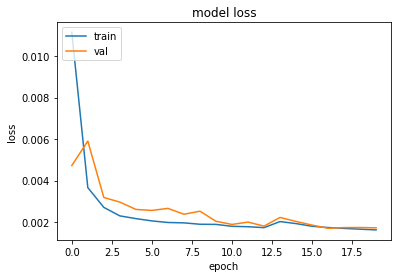

In [ ]:
from matplotlib import pyplot as plt
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(test_ds)

100/100 [==============================] - 8s 23ms/step - loss: 0.0017 - mean_squared_error: 0.0017


[0.0017018963117152452, 0.001701896544545889]

In [ ]:
# you need a few more libraries to work with ONNX
!pip install tf2onnx onnxruntime onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
i = 0
data = []
labels = []
for x,y in test_ds:
  data.append(x)
  labels.append(y)


In [ ]:
data = np.array(data)
labels = np.array(labels)

In [ ]:
data_x[0].shape

(192, 384, 3)

In [ ]:
loaded_mdl = tf.keras.models.load_model('/content/drive/MyDrive/Hinton_Project/Group14_hinton.h5')
prediction = loaded_mdl.predict(data_x)
prediction = np.squeeze(prediction)

125/125 [==============================] - 18s 73ms/step


In [ ]:
unrolled_data = data.reshape(data.shape[0]*data.shape[1],data.shape[2], data.shape[3], data.shape[4])


In [ ]:
prediction.shape

(4000, 192, 384)

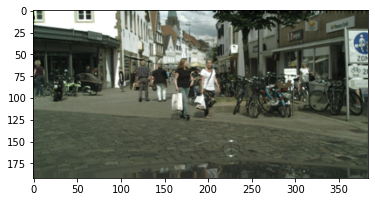

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(data_x[500])


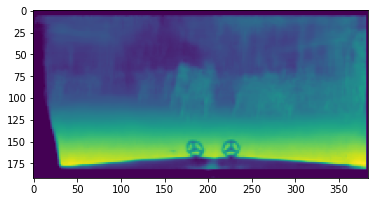

In [ ]:
plt.imshow(prediction[500])

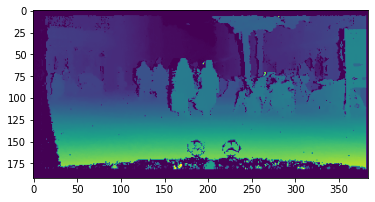

In [ ]:
plt.imshow(data_y[500])

In [ ]:
unrolled_labels = labels.reshape(labels.shape[0]*labels.shape[1],labels.shape[2], labels.shape[3])

## Dummy benchmarks

In [ ]:
import time
import onnx
import onnxruntime as ort


# benchmark in tensorflow
loaded_mdl = tf.keras.models.load_model('/content/drive/MyDrive/Hinton_Project/Group14_hinton.h5')

# dummy dataset
# test_data = #np.clip(128 + 50 *np.random.randn(16, 192, 384, 3), 0, 255).astype(np.uint8)
# test_labels = #np.clip(128 + 50 *np.random.randn(16, 192, 384), 0, 255)/256
# test_data = list(map(lambda x: x[0], test_ds))
# test_labels = list(map(lambda x: x[1], test_ds))
error = 0
start_time = time.time()
for cnt in range(len(unrolled_data)):
    pred = loaded_mdl.predict(np.expand_dims(unrolled_data[cnt], 0))
    #pred = model.predict(np.expand_dims(unrolled_data[cnt], 0))
    error += np.sum((unrolled_labels[cnt] - np.squeeze(pred))**2)
runtime = time.time() - start_time
print(f'Python MSE = {error/(cnt+1)}, runtime = {runtime/(cnt+1)}')

1/1 [==============================] - 0s 18ms/step
Python MSE = 111.90701598644256, runtime = 0.052015597820281985


In [ ]:
onnx.checker.check_model(onnx.load('/content/drive/MyDrive/Hinton_Project/Group14_hinton.onnx'))
ort_sess = ort.InferenceSession('/content/drive/MyDrive/Hinton_Project/Group14_hinton.onnx')

error = 0
start_time = time.time()
cnt = 0
while cnt*batch_size < len(unrolled_data):
    onnx_out = ort_sess.run(None, {'input_1': unrolled_data[cnt*batch_size:(cnt+1)*batch_size, :, :, :]})
    pred = np.squeeze(onnx_out).ravel()
    error += np.sum((unrolled_labels[cnt*batch_size:(cnt+1)*batch_size].ravel() - pred)**2)
    cnt += 1
runtime = time.time() - start_time
print(f'ONNX MSE = {error/cnt/batch_size}, runtime = {runtime/cnt/batch_size}')

ONNX MSE = 111.90701568603515, runtime = 0.047876150608062745
